## Task 2: Change Point Modeling and Insight Generation


In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd

df_check = pd.read_csv('../data/raw/BrentOilPrices.csv')
print(df_check.columns)
df_check.head()


Index(['Date', 'Price'], dtype='object')


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


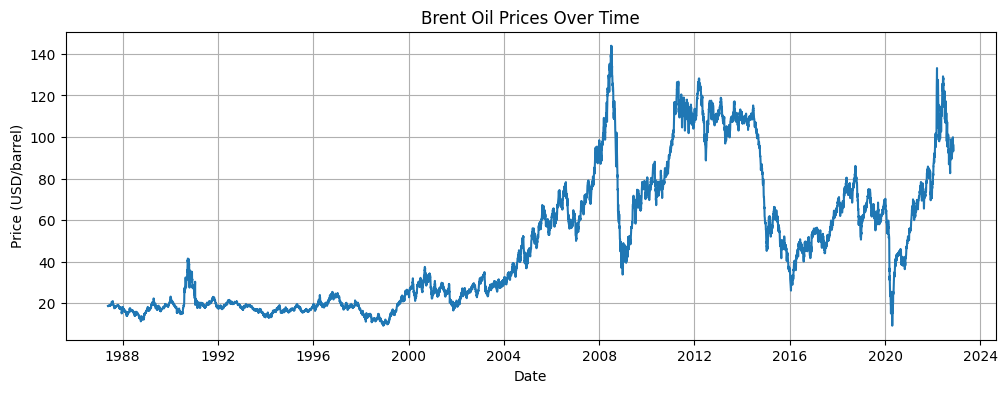

In [3]:
df = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'])

# Step 2: Rename 'Date' to 'date' for consistency
df.rename(columns={'Date': 'date', 'Price': 'price'}, inplace=True)

# Step 3: Sort and reset index
df = df.sort_values('date')
df.reset_index(drop=True, inplace=True)

# Step 4: Visualize the time series
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['price'])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD/barrel)")
plt.grid(True)
plt.show()

## Data preparation and EDA

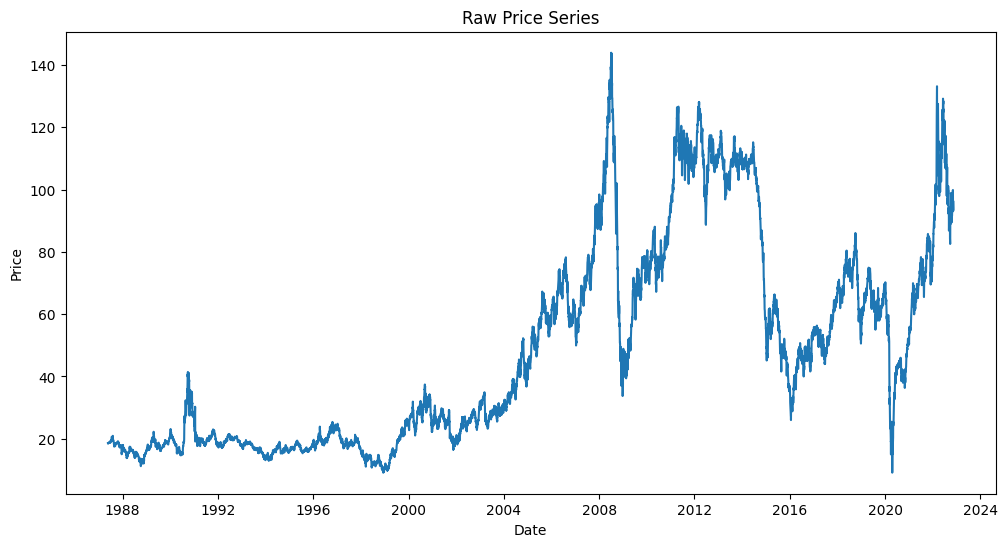

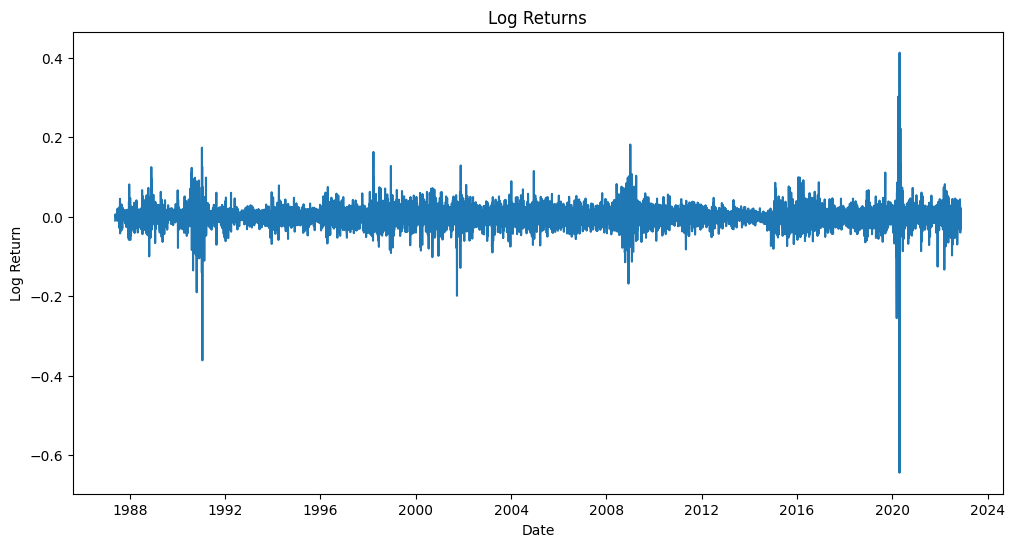

In [4]:
# Convert Date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by Date if not already sorted
df = df.sort_values('date').reset_index(drop=True)

# Plot raw price series
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price'])
plt.title('Raw Price Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculate log returns
df['log_return'] = np.log(df['price']) - np.log(df['price'].shift(1))
df = df.dropna(subset=['log_return'])

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['log_return'])
plt.title('Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

date          0
price         0
log_return    0
dtype: int64
             price   log_return
count  9010.000000  9010.000000
mean     48.424089     0.000179
std      32.860435     0.025532
min       9.100000    -0.643699
25%      19.050000    -0.011154
50%      38.600000     0.000402
75%      70.095000     0.012127
max     143.950000     0.412023
ADF Statistic: -16.4271
p-value: 0.0000


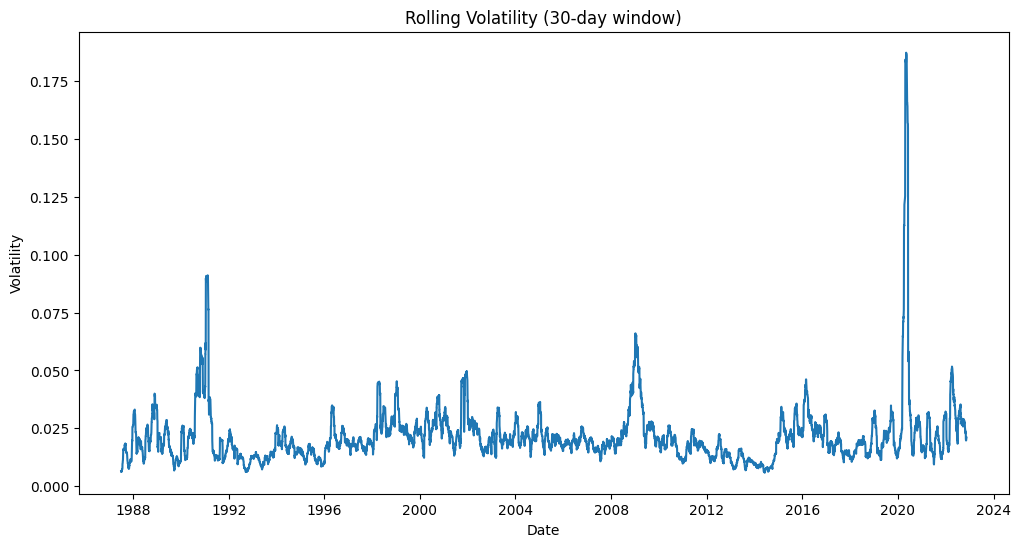

In [5]:
# Check for missing data
print(df.isnull().sum())

# Summary statistics
print(df[['price', 'log_return']].describe())

# Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['log_return'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

# Plot rolling volatility (rolling std of log returns)
window = 30  # e.g., 30 days
df['rolling_volatility'] = df['log_return'].rolling(window).std()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['rolling_volatility'])
plt.title('Rolling Volatility (30-day window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()


## Bayesian Change Point Model in PyMC3

In [6]:
import pymc3 as pm
import numpy as np
import arviz as az

# Assuming you already have your log returns in a NumPy array:
log_returns = df['log_return'].values
n = len(log_returns)

with pm.Model() as change_point_model:
    # Discrete uniform prior for switch point tau
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)
    
    # Priors for the means before and after the change point
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)
    
    # Prior for the standard deviation of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Use a switch to select mu1 or mu2 based on whether time < tau
    mu = pm.math.switch(np.arange(n) <= tau, mu1, mu2)
    
    # Likelihood connecting observed data with model
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)
    
    # Sample from the posterior using MCMC
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma, mu2, mu1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
There were 594 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695236803816472, but should be close to 0.8. Try to increase the number of tuning steps.
There were 650 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32141499645569416, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma, mu2, mu1]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 11 seconds.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6292794079937617, but should be close to 0.9. Try to increase the number of tuning steps.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


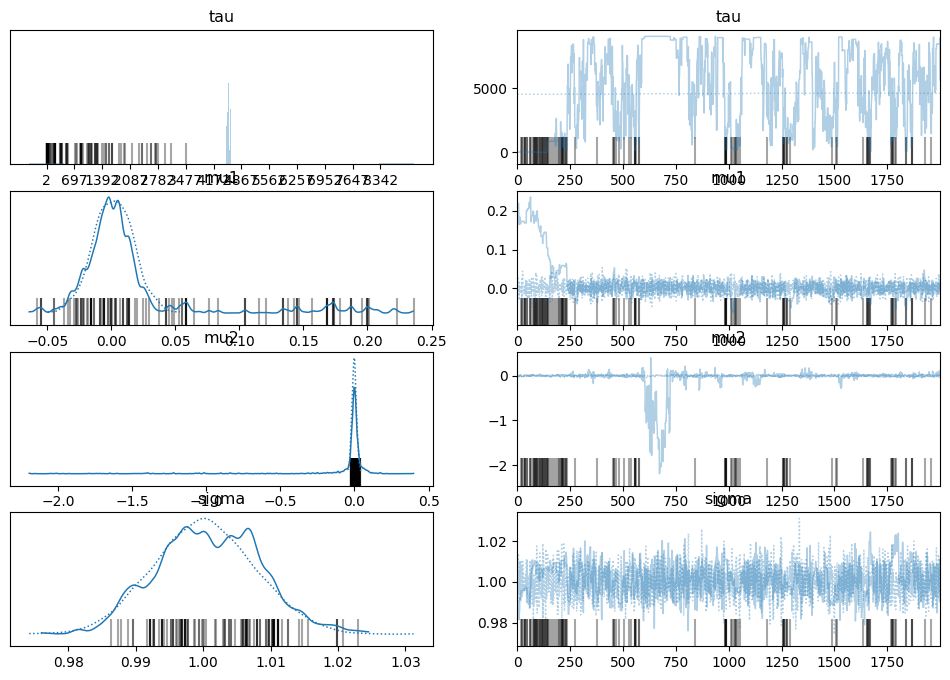

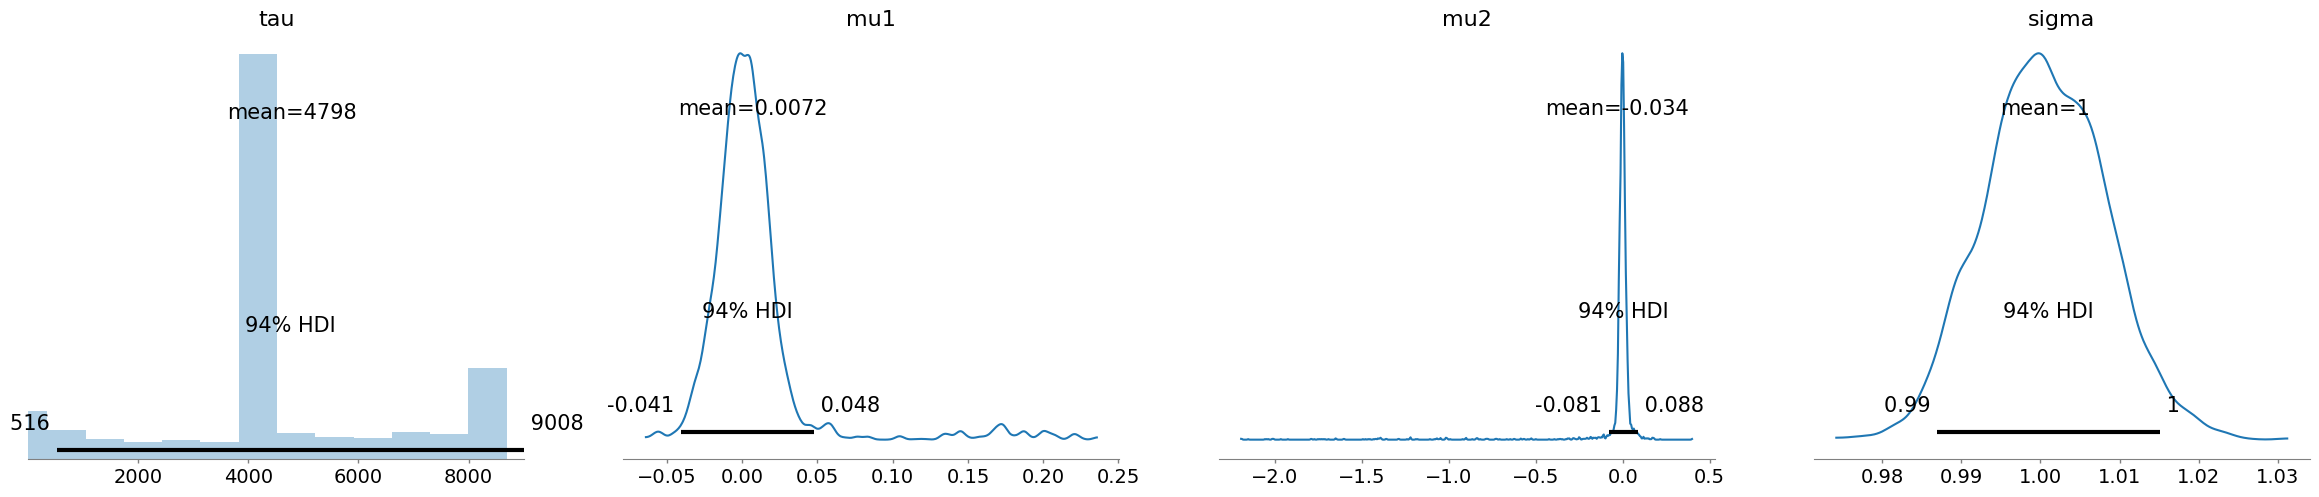

In [9]:
# Assume your DataFrame has 'log_return'
log_returns = df['log_return'].values
log_returns = (log_returns - np.mean(log_returns)) / np.std(log_returns)
n = len(log_returns)

with pm.Model() as change_point_model:
    # Prior for change point
    tau = pm.DiscreteUniform('tau', lower=0, upper=n - 1)

    # Priors for means
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Prior for std deviation
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Switching mean
    mu = pm.math.switch(np.arange(n) <= tau, mu1, mu2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Assign step methods explicitly
    step1 = pm.Metropolis(vars=[tau])  # for discrete variable
    step2 = pm.NUTS(vars=[mu1, mu2, sigma], target_accept=0.9)  # for continuous ones

    trace = pm.sample(
        draws=2000,
        tune=1500,
        step=[step1, step2],
        return_inferencedata=True,
        cores=1
    )

# Summary
az.summary(trace)

# Plots
az.plot_trace(trace)
plt.show()

az.plot_posterior(trace)
plt.show()

### ✅ PyMC3 Sampling Summary

* **Chains**: 2 chains × (1500 tune + 2000 draw)
* **Runtime**: \~11 seconds
* **Sampling Divergences**: `0` ✅
* **Tuning Divergences**: `124` ⚠️ (monitor, but OK if sampling is clean)
* **Acceptance Prob.**: Should be between `0.6 – 0.9`
* **Trace Plots**:

  * Chains should mix well (no drift/sticking)
  * `tau`, `mu1`, `mu2`, `sigma` should show stable behavior

---

### 🔍 Diagnostics Tips

| Issue                   | Suggestion                           |
| ----------------------- | ------------------------------------ |
| High tuning divergences | Set `target_accept=0.95`             |
| Poor mixing / low ESS   | Use `pm.find_MAP()` or reparametrize |
| Noisy `tau` estimates   | Add stronger priors                  |
